In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
import hashlib
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [78]:
FAST_RUN = False
IMAGE_WIDTH=512
IMAGE_HEIGHT=512
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=16

In [46]:
PATH = r'C:\Users\Artem\nsfw_data_scraper\data\new\train'
PATH_PORN = r'C:\Users\Artem\nsfw_data_scraper\data\train\porn'
PATH_NEUTRAL = r'C:\Users\Artem\nsfw_data_scraper\data\train\neutral'

In [6]:
PATH_TEST = r'C:\Users\Artem\nsfw_data_scraper\data\new\test'
PATH_PORN_TEST = r'C:\Users\Artem\nsfw_data_scraper\data\test\porn'
PATH_NEUTRAL_TEST = r'C:\Users\Artem\nsfw_data_scraper\data\test\neutral'

# Preprocess images

In [45]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

In [47]:
def remove_duplicates(file_hash, path, new_name):
    duplicates = []
    os.chdir(path)
    file_list = os.listdir(path)
    for count, filename in enumerate(os.listdir(path)): 
        dst = new_name + '.' + str(count) + ".jpg"
        src = os.path.join(path, filename)
        dst = os.path.join(path, dst)
        try:
            os.rename(src, dst)
        except:
            pass
    
    file_list = os.listdir()
    hash_keys = dict()
    for index, filename in enumerate(os.listdir('.')):
        if os.path.isfile(filename):
            with open(filename, 'rb') as f:
                filehash = hashlib.md5(f.read()).hexdigest()
            if filehash not in hash_keys:
                hash_keys[filehash] = index
            else:
                duplicates.append((index, hash_keys[filehash]))
                
    for index in duplicates:
        try:
            os.remove(file_list[index[0]])
        except Exception as e:
            print(e)
    return len(duplicates)

In [48]:
def move_file(path_src, path_dst):
    import shutil
    os.chdir(path_src)
    files = os.listdir()
    for file in files:
        try:
            shutil.move(path_src+'\\'+file, path_dst+'\\'+file)
        except:
            pass

In [49]:
def remove_invalid_images(path):
    os.chdir(path)
    i = 0
    for filename in os.listdir(path): 
        if os.path.isfile(path):
            try:
                im = Image.open(path + '\\' + filename)
                im.verify()
            except:
                os.remove(path + '\\' + filename)
                i += 1
    print(f'Removed {i} invalid images')

In [50]:
duplicates_porn = remove_duplicates(file_hash, PATH_PORN, 'porn')
print(f'Deleted {duplicates_porn} dublicated images with porn')
duplicates_neutral = remove_duplicates(file_hash, PATH_NEUTRAL, 'neutral')
print(f'Deleted {duplicates_neutral} dublicated neutral images')
move_file(PATH_PORN, PATH)
move_file(PATH_NEUTRAL, PATH)
remove_invalid_images(PATH)

Deleted 0 dublicated images with porn
Deleted 0 dublicated neutral images
Removed 0 invalid images


In [51]:
duplicates_porn_test = remove_duplicates(file_hash, PATH_PORN_TEST, 'porn')
print(f'Deleted {duplicates_porn_test} dublicated images with porn')
duplicates_neutral_test = remove_duplicates(file_hash, PATH_NEUTRAL_TEST, 'neutral')
print(f'Deleted {duplicates_neutral_test} dublicated neutral images')
move_file(PATH_PORN_TEST, PATH_TEST)
move_file(PATH_NEUTRAL_TEST, PATH_TEST)
remove_invalid_images(PATH_TEST)

Deleted 0 dublicated images with porn
Deleted 0 dublicated neutral images
Removed 0 invalid images


In [52]:
filenames = os.listdir(PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'porn':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<AxesSubplot:>

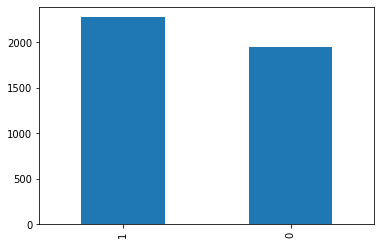

In [53]:
df['category'].value_counts().plot.bar()

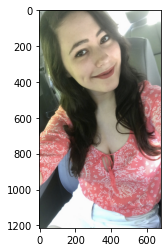

In [14]:
sample = random.choice(filenames)
image = load_img(PATH+'\\'+sample)
plt.imshow(image)

## Image augmentation with keras

In [88]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
train_df['category'] = train_df['category'].astype(str)
validate_df = validate_df.reset_index(drop=True)
validate_df['category'] = validate_df['category'].astype(str)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
    
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
    
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
    
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3380 validated image filenames belonging to 2 classes.
Found 845 validated image filenames belonging to 2 classes.


In [83]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='raw'
)

Found 1 validated image filenames.


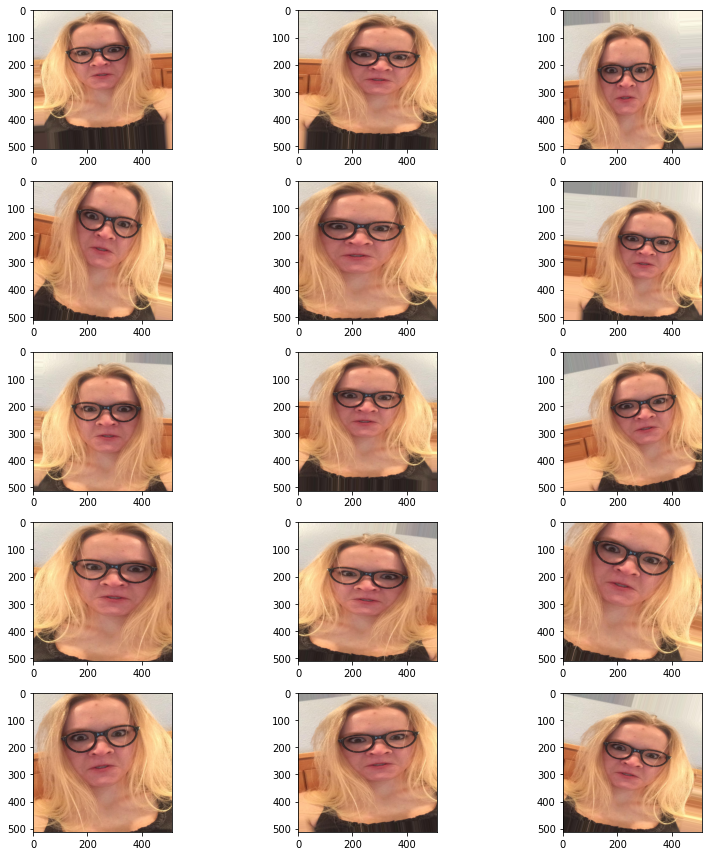

In [73]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [74]:
df["category"] = df["category"].replace({0: 'neutral', 1: 'porn'}) 

# Callbacks

In [76]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=r'C:\Users\Artem\nsfw_data_scraper\data\models',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [learning_rate_reduction, model_checkpoint_callback]

# Build NN

## Fine-tuning InceptionV3

In [38]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input

In [40]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

In [43]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=vgg_model.input, outputs=predictions)

for layer in vgg_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
epochs = 10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    )

Epoch 1/10
211/211 [==============================] - 210s 994ms/step - loss: 0.4655 - accuracy: 0.7776 - val_loss: 0.4731 - val_accuracy: 0.7536
INFO:tensorflow:Assets written to: C:\Users\Artem\nsfw_data_scraper\data\models\assets
Epoch 2/10
211/211 [==============================] - 204s 964ms/step - loss: 0.4258 - accuracy: 0.8056 - val_loss: 0.5011 - val_accuracy: 0.7680
INFO:tensorflow:Assets written to: C:\Users\Artem\nsfw_data_scraper\data\models\assets
Epoch 3/10
211/211 [==============================] - 208s 984ms/step - loss: 0.4247 - accuracy: 0.8059 - val_loss: 0.3861 - val_accuracy: 0.8269
INFO:tensorflow:Assets written to: C:\Users\Artem\nsfw_data_scraper\data\models\assets
Epoch 4/10
211/211 [==============================] - 208s 985ms/step - loss: 0.3836 - accuracy: 0.8273 - val_loss: 0.3812 - val_accuracy: 0.8293
INFO:tensorflow:Assets written to: C:\Users\Artem\nsfw_data_scraper\data\models\assets
Epoch 5/10
211/211 [==============================] - 208s 985ms/ste

In [39]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input

In [40]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input((512, 512, 3)))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    )

In [42]:
KFOLD_SPLITS = 5

skf = StratifiedKFold(n_splits=KFOLD_SPLITS, shuffle=True)

In [58]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

fold_var = 1

for train_index, val_index in skf.split(df['filename'],df['category']):
    
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]
    train_generator = train_datagen.flow_from_dataframe(
        training_data, 
        PATH, 
        x_col='filename',
        y_col='category',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size
    )
    
    validation_generator = validation_datagen.flow_from_dataframe(
        validation_data, 
        PATH, 
        x_col='filename',
        y_col='category',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size
    )
    # CREATE NEW MODEL
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input((512, 512, 3)))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
     
    epochs = 10
    history = model.fit(
        train_generator, 
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_data.shape[0]//batch_size,
        steps_per_epoch=training_data.shape[0]//batch_size,
        callbacks=callbacks
    )
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

Found 3380 validated image filenames belonging to 2 classes.
Found 845 validated image filenames belonging to 2 classes.
Epoch 1/10
140/140 [==============================] - 267s 2s/step - loss: 0.5036 - accuracy: 0.8067 - val_loss: 0.1826 - val_accuracy: 0.9286
INFO:tensorflow:Assets written to: C:\Users\Artem\nsfw_data_scraper\data\models\assets
Epoch 2/10
140/140 [==============================] - 255s 2s/step - loss: 0.2622 - accuracy: 0.8966 - val_loss: 0.2572 - val_accuracy: 0.9071
Epoch 3/10
140/140 [==============================] - 269s 2s/step - loss: 0.2708 - accuracy: 0.8932 - val_loss: 0.1714 - val_accuracy: 0.9357
INFO:tensorflow:Assets written to: C:\Users\Artem\nsfw_data_scraper\data\models\assets
Epoch 4/10
140/140 [==============================] - 265s 2s/step - loss: 0.2349 - accuracy: 0.9115 - val_loss: 0.1718 - val_accuracy: 0.9321
Epoch 5/10
140/140 [==============================] - 256s 2s/step - loss: 0.2098 - accuracy: 0.9185 - val_loss: 0.1897 - val_accurac

140/140 [==============================] - 203s 1s/step - loss: 0.1748 - accuracy: 0.9315 - val_loss: 0.2682 - val_accuracy: 0.9012
Epoch 6/10
140/140 [==============================] - 203s 1s/step - loss: 0.1860 - accuracy: 0.9265 - val_loss: 0.2521 - val_accuracy: 0.9036

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/10
140/140 [==============================] - 203s 1s/step - loss: 0.1672 - accuracy: 0.9404 - val_loss: 0.2557 - val_accuracy: 0.9048
Epoch 8/10
140/140 [==============================] - 204s 1s/step - loss: 0.1614 - accuracy: 0.9395 - val_loss: 0.2538 - val_accuracy: 0.9036
Epoch 9/10
140/140 [==============================] - 204s 1s/step - loss: 0.1910 - accuracy: 0.9296 - val_loss: 0.2539 - val_accuracy: 0.9024

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 10/10
140/140 [==============================] - 204s 1s/step - loss: 0.1702 - accuracy: 0.9376 - val_loss: 0.2554 - val_accur

### Model Saving and plot train/val Loss and Acc

In [60]:
model.save("model_finetuning.h5")

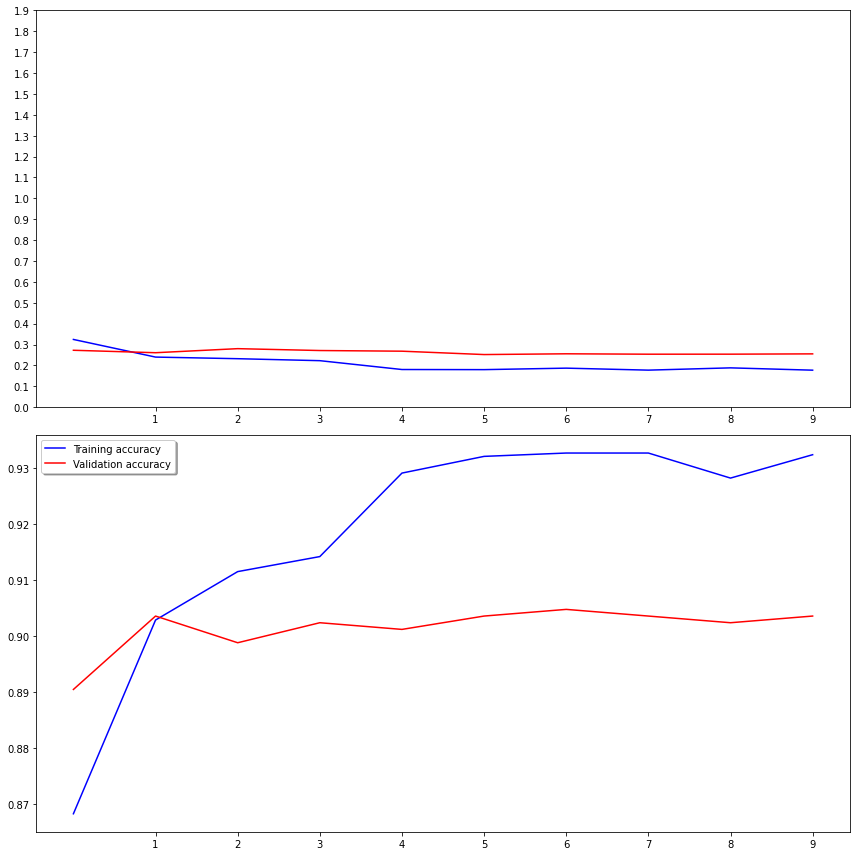

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Predict test data

In [7]:
test_filenames = os.listdir(PATH_TEST)

categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'porn':
        categories.append(1)
    else:
        categories.append(0)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'real_cat': categories
})
nb_samples = test_df.shape[0]

In [26]:
batch_test = test_df[:batch_size]

In [23]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    PATH_TEST, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1004 validated image filenames.


In [31]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['pred_cat'] = np.argmax(predict, axis=-1)
label_map = {'neutral':0,'porn':1}
test_df['pred_cat'] = test_df['pred_cat'].replace(label_map)
test_df['pred_cat'] = test_df['pred_cat'].replace({ 'porn': 1, 'neutral': 0 })

### Загрузка модели

In [ ]:
PATH = r'C:\Users\Artem\nsfw_data_scraper\data\models'
model = tf.keras.models.load_model(path)

### Время инференса одного изображения

In [32]:
IMAGE_PATH = r'C:\Users\Artem\Desktop\projects\for_demotivator.jpg'

In [36]:
image = Image.open(IMAGE_PATH)
image_resize = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
image_arr = np.asarray(image_resize) / 255
mean = np.mean(image_arr)
std_dv = np.std(image_arr)
image_arr = (image_arr - mean) / std_dv
image_arr = image_arr.reshape((1, IMAGE_WIDTH, IMAGE_HEIGHT, 3))

In [37]:
import time
start_time = time.time()

predict = model.predict(image_arr)

print("--- %s seconds ---" % (time.time() - start_time))

predicted = np.argmax(predict, axis=-1)

--- 0.07301640510559082 seconds ---


### Время  инференса одного батча

In [27]:
batch_gener = test_gen.flow_from_dataframe(
    batch_test,
    PATH_TEST,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 24 validated image filenames.


In [30]:
import time
start_time = time.time()

predict = model.predict(batch_gener)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8108196258544922 seconds ---


### Метрики

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print(confusion_matrix(test_df['real_cat'].values, test_df['pred_cat'].values), '\n')
print('f1_score:', f1_score(test_df['real_cat'].values, test_df['pred_cat'].values), '\n')
print('Accuracy:', accuracy_score(test_df['real_cat'].values, test_df['pred_cat'].values), '\n')

[[473  37]
 [ 37 457]] 

f1_score: 0.9251012145748988 

Accuracy: 0.9262948207171314 

